# Сборный проект №1

Задача:
- необходимо проанализировать данные по проданным компьютерным играм по всему миру
- выявить критерии и закономерности, определяющие успешность игры 

In [1]:
# импортируем библиотеки, которые будут использованы в дальнейшем анализе
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

##  1. Откроем файл с данными и изучим общую информацию

In [2]:
data = pd.read_csv('/Users/uliabubnova/Downloads/games.csv')
display(data.head())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
# приведем все названия колонок к нижнему регистру
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [4]:
# функция, которая выдает основную информацию о датафрейме
def info_df(data):
    display(data.info(), 
          data.describe(), 
          data.isna().sum(), 
          data.duplicated().sum(),
          data.duplicated(subset = ['name', 'platform']).sum())
    
info_df(data)    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

0

5

Первые выводы о имеющихся данных: 
- в имеющемся датафрейме 16715 строк
- пропуски в названиях, жанре и годе выпуска игр можно удалить, так как в сумме их менее 2% - это не повлияет на дальнейший анализ
- большое количество пропусков в столбцах с оценками пользователей/критиков и рейтингом - их необходимо проанализировать детальнее, чтобы принять решение, как с ними поступить
- явных дубликатов в датафрейме нет
- в пяти строках игры и платформы дублируются - это незначительное дублирование, поэтому можем это оставить как есть
- в столбцах с годом выпуска, оценками критиков и пользователей необходимо изменить тип данных


# 2. Предобработка данных

In [5]:

data_nan = data.query('year_of_release.isna() or genre.isna() or name.isna()')
data_nan_sales = data_nan[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)
data_nan_sales.sort_values(ascending=False).head(10)

183    5.24
377    3.50
456    3.06
475    3.00
609    2.53
627    2.47
657    2.40
659    2.39
678    2.33
719    2.24
dtype: float64

In [6]:
#удалим пропуски в трех столбцах
data = data.dropna(subset=['year_of_release', 'genre', 'name'])

#проверим, что пропуски исчезли, как нужно
data[['year_of_release', 'genre', 'name']].isna().sum()

year_of_release    0
genre              0
name               0
dtype: int64

In [7]:
# рассммотрим, какие сущетсвуют оценки критиков
data['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

- оценки критиков  - это целые числа в диапазоне [0,100]
- половина игр не имеют оценки. Этом может быть связано, что игра мало известна, недавно вышла на рынок или наоборот очень давно и про нее все забыли,  также с крайне низкой популярностью игры
- так как пропусков около 50% - удалить их мы не можем, т.к. это может сильно повлиять на дальнейшие выводы, поэтому пропущенные значения заменим на `-5` 

In [8]:
data['critic_score'] = data['critic_score'].fillna(-5)

In [9]:
# рассммотрим, какие сущетсвуют оценки пользователей
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [10]:
data.query('user_score =="tbd"')['name'].count()

2376

- пользователи оценивают игру в диапазоне [0,10]
- около 40% - это пропущенные значения. Причины могут быть аналогичными, как с оценками критиков: малоизвестная игра, непопулярная, устаревшая и тп
- значение tbd - указывает на то, что рейтинг еще не определен или расчитывается
- так как пропущеных и неопределенных значений более 50% - их удалять тоже не станем, а заменим на "заглушки"

In [11]:
data['user_score'] = data['user_score'].fillna(-5.)
data['user_score'] = data['user_score'].replace('tbd', -10.)

In [12]:
# заменим пропуске рейтингов на строку 'without_rating'
data['rating'] = data['rating'].fillna('without_rating')

### Изменим тип данных

Приведем столбцы с годом выпуcка и оценками критиков и пользователей к минимально допустимым типам

In [13]:
data['year_of_release'] = data['year_of_release'].astype('int16')
data['critic_score'] = data['critic_score'].astype('int8')
data['user_score'] = data['user_score'].astype('float16')

In [14]:
# еще раз проверим данные в уже обработанном датафрейме
info_df(data) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int16  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  int8   
 9   user_score       16444 non-null  float16
 10  rating           16444 non-null  object 
dtypes: float16(1), float64(4), int16(1), int8(1), object(4)
memory usage: 1.2+ MB


None

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
count,16444.000000,16444.000000,16444.000000,16444.000000,16444.000000,16444.000000,16444.000000
mean,2006.486256,0.264012,0.145930,0.078487,0.047594,30.921734,-0.218872
std,5.875525,0.818378,0.506716,0.311100,0.188005,38.233228,6.964844
min,1980.000000,0.000000,0.000000,0.000000,0.000000,-5.000000,-10.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,-5.000000,-5.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,-5.000000,-5.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,70.000000,7.300781
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000,9.703125


name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

0

3

### Добавим столбец с продажами по каждой игре во всем мире

In [15]:
data.insert(8, "total_sales", data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales'])
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,82.54,76,8.000000,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,40.24,-5,-5.000000,without_rating
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,35.52,82,8.296875,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,32.77,80,8.000000,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,31.38,-5,-5.000000,without_rating


# 3 Исследовательский анализ данных

Посмотрим, сколько игр выпускалось в разные годы

In [16]:
data_games_per_yaer = data.groupby('year_of_release')['name'].count().reset_index()
data_games_per_yaer

,year_of_release,name
0,1980,9
1,1981,46
2,1982,36
3,1983,17
4,1984,14
5,1985,14
6,1986,21
7,1987,16
8,1988,15
9,1989,17


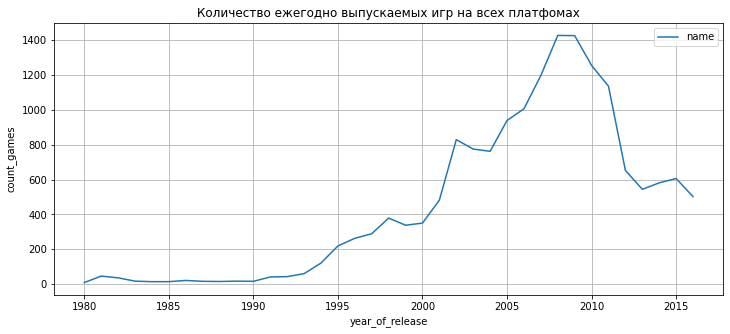

In [17]:
data_games_per_yaer.plot(x = 'year_of_release', y = 'name', grid=True, figsize=(12,5))\
.set_title('Количество ежегодно выпускаемых игр на всех платфомах');
plt.ylabel("count_games");

После 1995 года рынок компьютерных игр начал постепенно расти. Пик был в 2008-2009 гг, когда было выпущено максимальное количество новых игр.
Затем после 2012 года был провал (видимо приставки уже начали устаревать, и на смену им только начали приходить новые технологии)

Посмотрим, как менялись продажи по платформам.

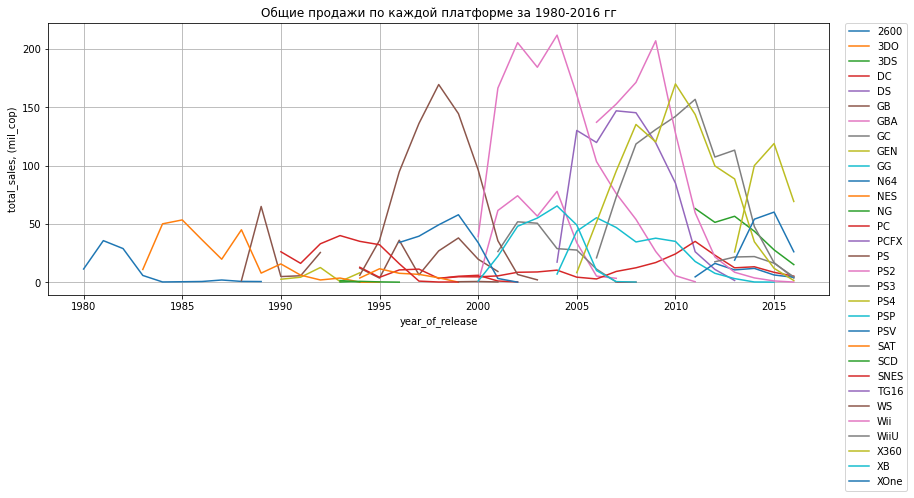

In [18]:
data_group_games = data.pivot_table\
(index = 'year_of_release', columns ='platform', values = 'total_sales', aggfunc = 'sum')

data_group_games.plot(grid=True, figsize=(14,5))\
.set_title('Общие продажи по каждой платформе за 1980-2016 гг');
plt.ylabel("total_sales, (mil_cop)");
plt.legend(bbox_to_anchor=(1.02 , 1), loc='upper left', borderaxespad = 0);

По графикам можно явно заметить, что примерный срок жизни каждой платформы около 10 лет. Действительно после 2010 года популярные на тот момент платформы, видимо, начали казаться устаревшими. Уже появились новые технологии и рынок ждал выхода более совремнных платформ.

In [19]:
# рейтинг мировых продаж игр для каждой платформы за весь исследуемый период
data_sales_platforms_sort = data.pivot_table\
(index ='platform', values = 'total_sales', aggfunc = 'sum').sort_values(by='total_sales', ascending = False)
data_sales_platforms_sort.head(10)

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


Можно выделить 6 платформ, которые к 2016 году явно лидировали по продажам игр в мире

In [20]:
# Топ-6 платформ
data_sales_platforms_top6 = data_sales_platforms_sort[:6]
data_sales_platforms_top6

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58


Рассмотрим отдельно продажи по годам топовых платформ

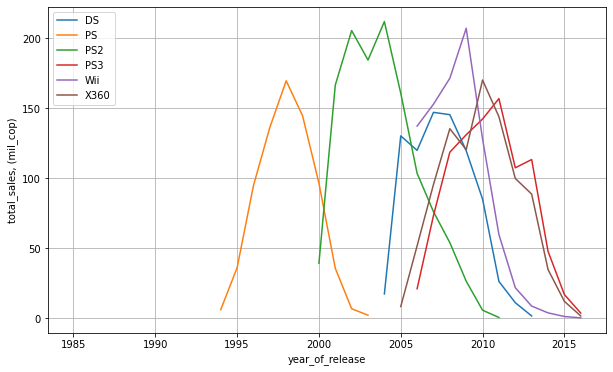

In [21]:
data.query('platform in @data_sales_platforms_top6.index').pivot_table\
(index = 'year_of_release', columns ='platform', values = 'total_sales', aggfunc = 'sum')\
.plot(grid=True,figsize=(10,6));

plt.ylabel("total_sales, (mil_cop)");
plt.legend(loc='upper left');

- Еще раз убеждаемся в том, что срок жизни популярной платформы 10 лет. 
- Есть резкий подъем, когда платформа набирает популярность за 2-3 года, а последние 3 года такой же резкий спад до 0 (то есть игры совсем перестают выпускать на устаревшие приставки)
- Как только появляется новая технология в мире, приставки основанные на прошлых технологиях начинают тут же устаревать. На графиках заметны пересечения именно в местах спада и подъема циклов цизни приставок


Так как в компьютерных технологиях все достаточно быстро меняется, не стоит для прогнозирования брать всю историю продаж. Дотаточно выделить последний интревал в 2-3 года. Возьмем за актуальный период данные с 2013 года - так как именно в этот период наблюдается смена технологий (старые приставки безвозвратно устарели и появились новые современные модели). 
Ограничим актуальный период 2015 годом, так как за 2016 год данные еще не полные

### Далее будем работать только с актуальным периодом

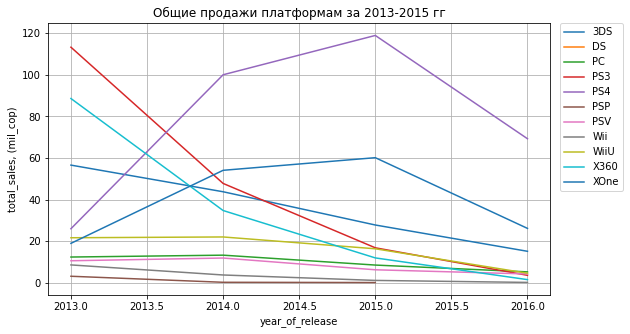

In [22]:
#  ограничим датафрейм актуальным периодом (2013-2016 гг)
data_topical = data.query('year_of_release >=2013')

# попстоим графики ихменения продаж по разым платформам за актуальный период
data_topical.pivot_table(index = 'year_of_release', columns ='platform', values = 'total_sales', aggfunc = 'sum')\
.plot(grid=True,figsize=(9,5)).set_title('Общие продажи платформам за 2013-2015 гг');
plt.ylabel("total_sales, (mil_cop)");
plt.legend(loc='upper left');
plt.legend(bbox_to_anchor=(1.02 , 1), loc='upper left', borderaxespad= 0 );

Ярко выделяются две новые трендовые приставки PS4 и XOne, которые претендуют занять лидирущее место на рынке компьютерных игр.

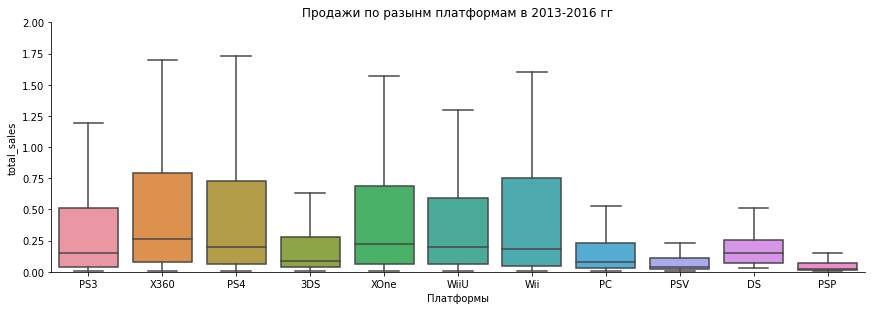

In [23]:
sns.catplot(x="platform", 
            y='total_sales', 
            kind="box", 
            data=data_topical, 
            orient='v', 
            height=4, 
            aspect=3,
           showfliers=False)\
.set(title = 'Продажи по разынм платформам в 2013-2016 гг', xlabel = 'Платформы', ylabel = 'total_sales');

plot = plt.ylim(0, 2);

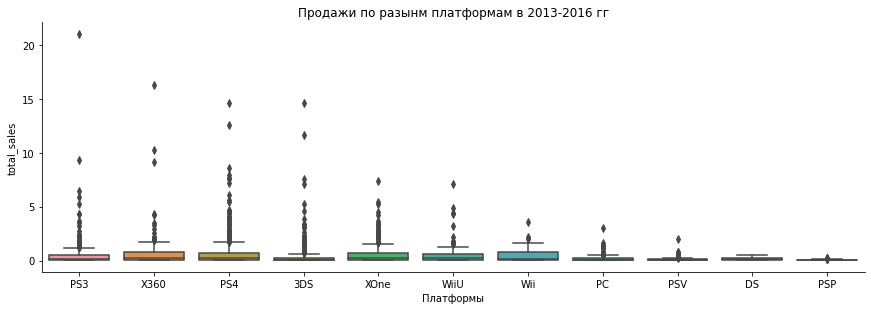

In [24]:
sns.catplot(x="platform", 
            y='total_sales', 
            kind="box", 
            data=data_topical, 
            orient='v', 
            height=4, 
            aspect=3)\
.set(title = 'Продажи по разынм платформам в 2013-2016 гг', xlabel = 'Платформы', ylabel = 'total_sales');


Ящики с усами позволяют оценить разброс значений в распределнии. Видим, что межквартильный размах значений и медиана ящиков у современных приставок (PS4, XOne) больше. Они уже опережают платформы прошлого поколения, а если учесть, что они только недавно появились на рынке, то можно уверенно прогнозировать дальнейший рост продаж.

### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.

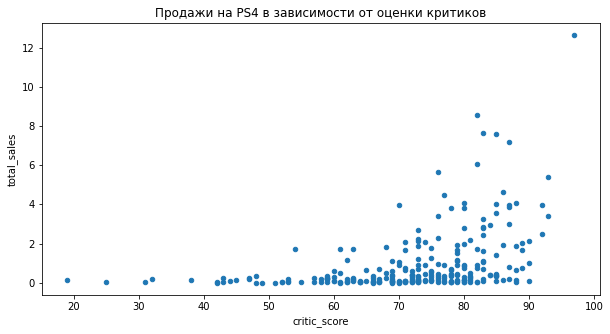

Корреляция между продажами и оценками критиков для PS4 = 0.40589480145836687


In [25]:
# сделаем срез по PS4, имеющим оценки
data_score_PS4 = data_topical.query('critic_score > 0 & user_score > 0 & platform == "PS4"')

# строим диаграмму рассеиния
data_score_PS4.plot(x='critic_score', y='total_sales', kind='scatter', figsize = (10,5), \
                      title = 'Продажи на PS4 в зависимости от оценки критиков');
plt.show()

# корреляция
print('Корреляция между продажами и оценками критиков для PS4 =',\
      data_score_PS4['total_sales'].corr(data_score_PS4['critic_score']))

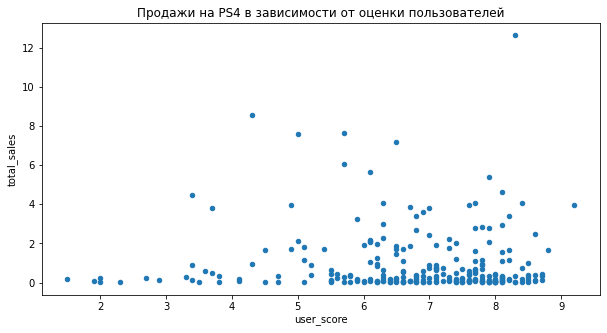

Корреляция между продажами и оценками пользователей для PS4 = -0.03369197213757457


In [26]:
# те же дейсчтвия для игр с оценкой пользователей
data_score_PS4.plot(x='user_score', y='total_sales', kind='scatter', figsize = (10,5), \
                      title = 'Продажи на PS4 в зависимости от оценки пользователей');
plt.show()
print('Корреляция между продажами и оценками пользователей для PS4 =',\
      data_score_PS4['total_sales'].corr(data_score_PS4['user_score']))

Вывод: наблюдается слабая прямая взаимосвязь между продажами игр и оценками критиков. Зависимости между продажами и оценками пользователей нет.

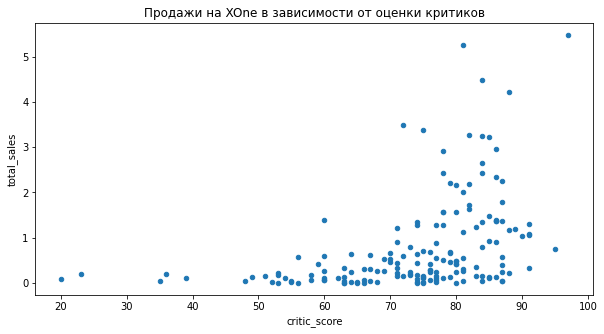

Корреляция между продажами и оценками критиков для XOne = 0.4104220356129637


In [27]:
# исследование взаимосвязи для XOne
data_score_XOne = data_topical.query('critic_score > 0 & user_score > 0 & platform == "XOne"')

data_score_XOne.plot(x='critic_score', y='total_sales', kind='scatter', figsize = (10,5), \
                      title = 'Продажи на XOne в зависимости от оценки критиков');
plt.show();
print('Корреляция между продажами и оценками критиков для XOne =',\
      data_score_XOne['total_sales'].corr(data_score_XOne['critic_score']))

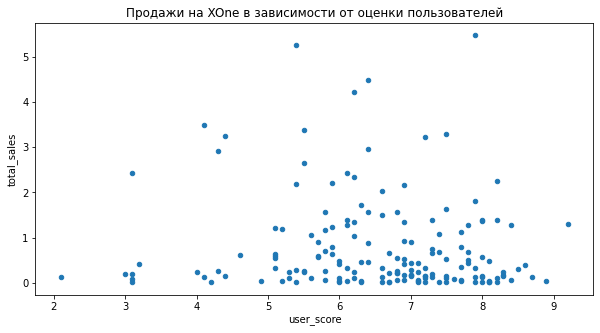

Корреляция между продажами и оценками пользователей для XOne = -0.09411292985030849


In [28]:
data_score_XOne.plot(x='user_score', y='total_sales', kind='scatter', figsize = (10,5), \
                      title = 'Продажи на XOne в зависимости от оценки пользователей');
plt.show()
print('Корреляция между продажами и оценками пользователей для XOne =',\
      data_score_XOne['total_sales'].corr(data_score_XOne['user_score']))

Вывод: Для платформы XOne видим аналогичный результат. Взаимосвязи продаж с оценками пользователей нет совсем, а с оценками критиков она слабая.

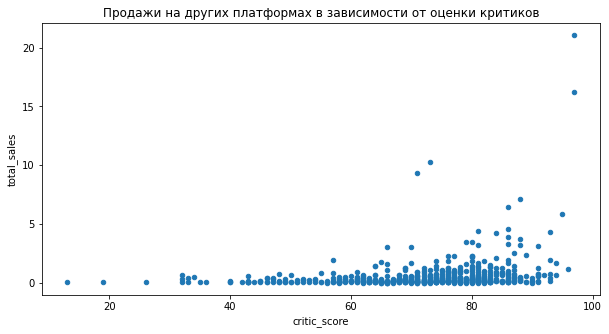

Корреляция между продажами и оценками критиков для остальных платформ = 0.25143683088147795


In [29]:
# изучим все остальные платформы единой группой
data_score_other = data_topical.query('critic_score > 0 & user_score > 0 &\
                                       platform != "XOne" & platform != "PS4"')

data_score_other.plot(x='critic_score', y='total_sales', kind='scatter', figsize = (10,5), \
                      title = 'Продажи на других платформах в зависимости от оценки критиков');
plt.show()
print('Корреляция между продажами и оценками критиков для остальных платформ =',\
      data_score_other['total_sales'].corr(data_score_other['critic_score']))

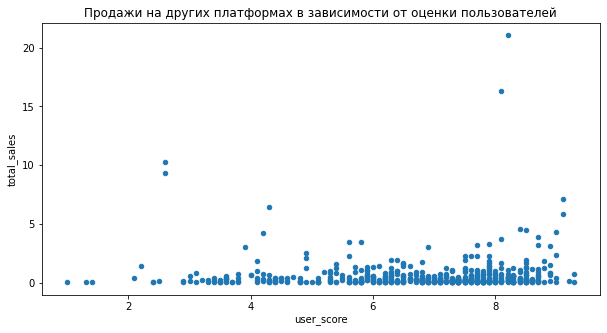

Корреляция между продажами и оценками пользователей для остальных платформ = 0.029502809422314206


In [30]:
data_score_other.plot(x='user_score', y='total_sales', kind='scatter', figsize = (10,5), \
                      title = 'Продажи на других платформах в зависимости от оценки пользователей');
plt.show();
print('Корреляция между продажами и оценками пользователей для остальных платформ =',\
      data_score_other['total_sales'].corr(data_score_other['user_score']))

Выводы не меняются. Взаимосвязь продаж по всем платформам не зависит напрямую от оценок пользоваелей и слабо зависит от оценок критиков.

## Рассмотрим общее распределение игр по жанрам

In [31]:
# сгруппируем игры по жанрам и определи количество, суммарные продажи и среднее
data_group_genre = data_topical.groupby('genre').agg({'total_sales':['count', 'sum', 'mean']}).reset_index()

# избавимся от двухуровневых заголовков
data_group_genre.columns = [tup[1] if tup[1] else tup[0] for tup in data_group_genre.columns]

# сначала отса=ортируем датафрейм по сумме продаж в каждом жанре
display(data_group_genre.sort_values(by='sum', ascending = False).reset_index())
# а затем по среднему доходу с игры
display(data_group_genre.sort_values(by='mean', ascending = False).reset_index())

,index,genre,count,sum,mean
0,0,Action,766,321.87,0.420196
1,8,Shooter,187,232.98,1.245882
2,10,Sports,214,150.65,0.703972
3,7,Role-Playing,292,145.89,0.499623
4,3,Misc,155,62.82,0.405290
5,4,Platform,74,42.63,0.576081
6,6,Racing,85,39.89,0.469294
7,2,Fighting,80,35.31,0.441375
8,1,Adventure,245,23.64,0.096490
9,9,Simulation,62,21.76,0.350968


,index,genre,count,sum,mean
0,8,Shooter,187,232.98,1.245882
1,10,Sports,214,150.65,0.703972
2,4,Platform,74,42.63,0.576081
3,7,Role-Playing,292,145.89,0.499623
4,6,Racing,85,39.89,0.469294
5,2,Fighting,80,35.31,0.441375
6,0,Action,766,321.87,0.420196
7,3,Misc,155,62.82,0.405290
8,9,Simulation,62,21.76,0.350968
9,5,Puzzle,17,3.17,0.186471


# 4 Составим портрет пользователя каждого региона

### Проанализируем, какие платформы популярны в Северной Америке

,platform,na_sales
0,PS4,108.74
1,XOne,93.12
2,X360,81.66
3,PS3,63.50
4,3DS,38.20
5,other,52.49


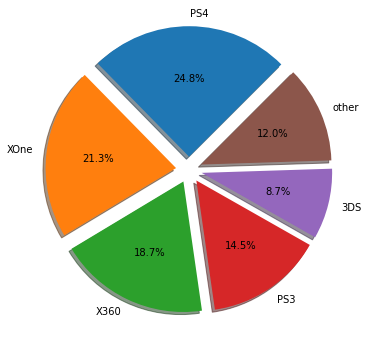

In [32]:
# сгруппируем продажи в Америке по каждой платформе
data_na_platforms = data_topical.groupby('platform')['na_sales'].sum().reset_index()\
                                               .sort_values(by='na_sales', ascending = False)
# выделим ТОП-5 лидеров
data_na_platforms_top5 = data_na_platforms[:5]
# остальные платформы соберем в отдельный датафрейм
data_other_na = data_na_platforms[5:]
# и добавим в конец строку с суммарными продажами по всем остальным платформам
data_na_platforms_top5 = data_na_platforms_top5.append({'platform': 'other', \
                                                        'na_sales': data_other_na['na_sales'].sum()}, \
                                                       ignore_index=True)
display(data_na_platforms_top5)

fig = plt.figure(figsize=(20,6))
plt.pie(data_na_platforms_top5['na_sales'], labels = data_na_platforms_top5['platform'], startangle=45 , \
        shadow='true', autopct='%1.1f%%',
       explode=[0.1,0.1,0.1, 0.1, 0.1, 0.1]);

Видим, что самые популярные платформы PS4, X360, XOne - они пока занимают примерно равные доли рынка. Снижается популярность PS3. Портативные консоли в Америке мало востребованы.

### Узнаем, на чем предпочитают играть в Европе

,platform,eu_sales
0,PS4,141.09
1,PS3,67.81
2,XOne,51.59
3,X360,42.52
4,3DS,30.96
5,other,58.26


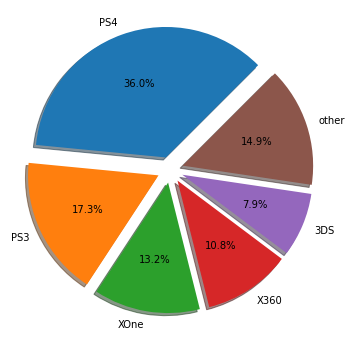

In [33]:
#  сосздадим срез по продажам в Европе и сгрупируем по платформе
data_eu_platforms = data_topical.groupby('platform')['eu_sales'].sum().reset_index()\
                                               .sort_values(by='eu_sales', ascending = False)

# выберем ТОП-5, а остальные платформы сгруппируем вместе
data_eu_platforms_top5 = data_eu_platforms[:5]
data_other_eu = data_eu_platforms[5:]

data_eu_platforms_top5 = data_eu_platforms_top5.append({'platform': 'other', \
                                                        'eu_sales': data_other_eu['eu_sales'].sum()}, \
                                                       ignore_index=True)
# выведем получившийся датафрейм и построим по нему круговую диаграмму
display(data_eu_platforms_top5)

fig = plt.figure(figsize=(20,6))
plt.pie(data_eu_platforms_top5['eu_sales'], labels = data_eu_platforms_top5['platform'], startangle=45 , \
        shadow='true', autopct='%1.1f%%',
       explode=[0.1,0.1,0.1, 0.1, 0.1, 0.1]);

В Европе лидирует все те же платформы, что и в Америке, но все таки заметно явное превосходство PS над другими приставками.

### Определим популярные платформы в Японии

,platform,jp_sales
0,3DS,67.81
1,PS3,23.35
2,PSV,18.59
3,PS4,15.96
4,WiiU,10.88
5,other,4.19


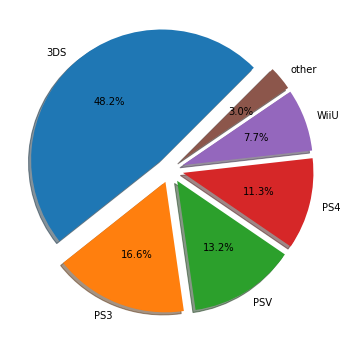

In [34]:
# проводим те же манипуляции: берем срез, сортируем, определяем ТОП-5
data_jp_platforms = data_topical.groupby('platform')['jp_sales'].sum().reset_index()\
                                               .sort_values(by='jp_sales', ascending = False)
data_jp_platforms_top5 = data_jp_platforms[:5]

data_other_jp = data_jp_platforms[5:]

data_jp_platforms_top5 = data_jp_platforms_top5.append({'platform': 'other', \
                                                        'jp_sales': data_other_jp['jp_sales'].sum()}, \
                                                       ignore_index=True)
# выводим датафрейм и диаграмму
display(data_jp_platforms_top5)

fig = plt.figure(figsize=(20,6))
plt.pie(data_jp_platforms_top5['jp_sales'], labels = data_jp_platforms_top5['platform'], startangle=45 , \
        shadow='true', autopct='%1.1f%%',
       explode=[0.1,0.1,0.1, 0.1, 0.1, 0.1]);

В Японии видим совсем другую картину. 70% всего игрового рынка занимают портативные консоли. Это резко отличает Японский рынок от Западного.

### Узнаем самые популярные жанры в Америке

,genre,na_sales
0,Action,126.05
1,Shooter,109.74
2,Sports,65.27
3,Role-Playing,46.40
4,Misc,27.49
5,other,62.76


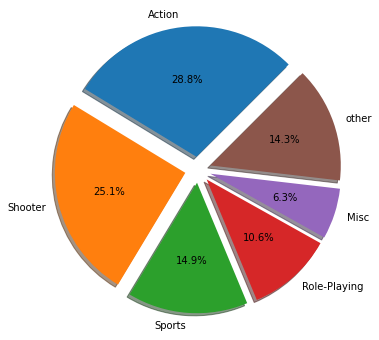

In [35]:
# на этот раз сгруппируем продажи в Америке по жанрам и выделим ТОП-5
data_na_genre = data_topical.groupby('genre')['na_sales'].sum().reset_index()\
                                               .sort_values(by='na_sales', ascending = False)
data_na_genre_top5 = data_na_genre[:5]

data_other_na = data_na_genre[5:]

data_na_genre_top5 = data_na_genre_top5.append({'genre': 'other', \
                                                        'na_sales': data_other_na['na_sales'].sum()}, \
                                                       ignore_index=True)
# визуализируем полученную информацию
display(data_na_genre_top5)

fig = plt.figure(figsize=(20,6))
plt.pie(data_na_genre_top5['na_sales'], labels = data_na_genre_top5['genre'], startangle=45 , \
        shadow='true', autopct='%1.1f%%',
       explode=[0.1,0.1,0.1, 0.1, 0.1, 0.1]);

Самые популярные в жанры это Экшн, "Стрелялки" и Спорт.

### Посмотрим какие прибыльные жанры игр в Европе

,genre,eu_sales
0,Action,118.13
1,Shooter,87.86
2,Sports,60.52
3,Role-Playing,36.97
4,Racing,20.19
5,other,68.56


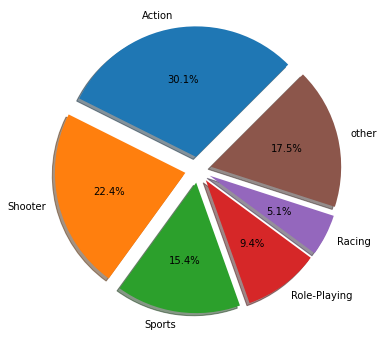

In [36]:
data_eu_genre = data_topical.groupby('genre')['eu_sales'].sum().reset_index()\
                                               .sort_values(by='eu_sales', ascending = False)
data_eu_genre_top5 = data_eu_genre[:5]

data_other_eu = data_eu_genre[5:]

data_eu_genre_top5 = data_eu_genre_top5.append({'genre': 'other', \
                                                        'eu_sales': data_other_eu['eu_sales'].sum()}, \
                                                       ignore_index=True)
display(data_eu_genre_top5)

fig = plt.figure(figsize=(20,6))
plt.pie(data_eu_genre_top5['eu_sales'], labels = data_eu_genre_top5['genre'], startangle=45 , \
        shadow='true', autopct='%1.1f%%',
       explode=[0.1,0.1,0.1, 0.1, 0.1, 0.1]);

Европейцы солидарны в своих предпочтениях с американцами. Им тоже больше всего нравятся динамичные игры

### Интересно какие жанры предпочитают японцы

,genre,jp_sales
0,Role-Playing,51.04
1,Action,40.49
2,Misc,9.20
3,Fighting,7.65
4,Shooter,6.61
5,other,25.79


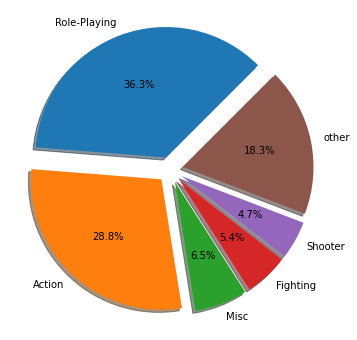

In [37]:
data_jp_genre = data_topical.groupby('genre')['jp_sales'].sum().reset_index()\
                                               .sort_values(by='jp_sales', ascending = False)
data_jp_genre_top5 = data_jp_genre[:5]

data_other_jp = data_jp_genre[5:]

data_jp_genre_top5 = data_jp_genre_top5.append({'genre': 'other', \
                                                        'jp_sales': data_other_jp['jp_sales'].sum()}, \
                                                       ignore_index=True)
display(data_jp_genre_top5)

fig = plt.figure(figsize=(15,6))
plt.pie(data_jp_genre_top5['jp_sales'], labels = data_jp_genre_top5['genre'], startangle=45 , \
        shadow='true', autopct='%1.1f%%',
       explode=[0.1,0.1,0.1, 0.1, 0.1, 0.1]);

Японцы опять отличились. Наиболее популярные жанры - Ролевые и Экшн. При чем ролевые игры забирают на себя более трети всего рынка, тогда как на Западе на их долю приходилось только 10% продаж.
А вот Спорт и "Стрелялки" японцам совсем не интересны, в отличие от западных пользовотелей.

### Определим, влияет ли рейтинг ESRB на продажи в отдельном регионе

In [38]:
# узнаем какие значения в столбце имеются
data_topical['rating'].value_counts()

without_rating    977
M                 369
T                 333
E                 302
E10+              252
Name: rating, dtype: int64

Определим общие продажи по каждому рейтингу для Северной Америки

rating
E                  79.05
E10+               54.24
M                 165.21
T                  49.79
without_rating     89.42
Name: na_sales, dtype: float64

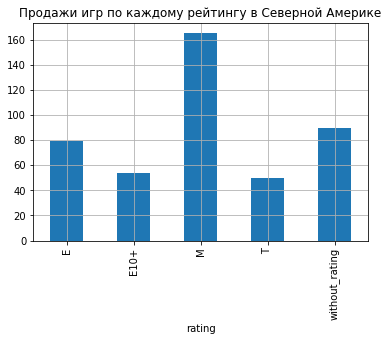

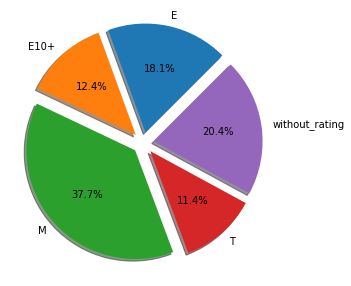

In [39]:
data_rating_na = data_topical.groupby('rating')['na_sales'].sum()
display(data_rating_na)


data_rating_na.plot(x='rating', y = 'na_sales', kind = 'bar', \
                                        title = 'Продажи игр по каждому рейтингу в Северной Америке', grid= True);

fig = plt.figure(figsize=(15,5))

data_rating_na = data_rating_na.reset_index()                                      
plt.pie(data_rating_na['na_sales'], labels = data_rating_na['rating'], startangle=45 , \
        shadow='true', autopct='%1.1f%%', explode=[0.1,0.1,0.1, 0.1, 0.1]);

В Америке наиболее популярны игры для взрослой аудитории (М) и для всех возрастов (Е). Но и игры без определенного рейтинга востребованы - их доля 20%

Сравним продажи по каждому рейтингу в Европе

rating
E                  83.36
E10+               42.69
M                 145.32
T                  41.95
without_rating     78.91
Name: eu_sales, dtype: float64

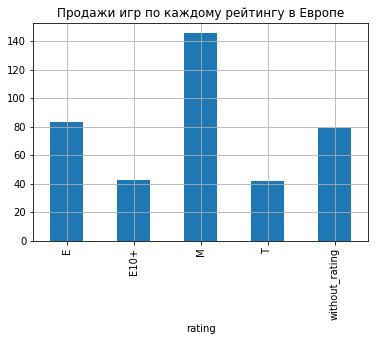

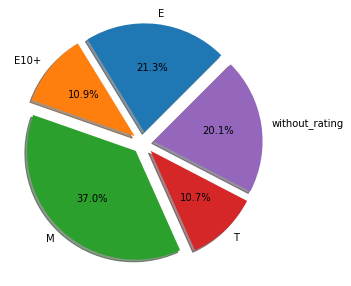

In [40]:
data_rating_eu = data_topical.groupby('rating')['eu_sales'].sum()
display(data_rating_eu)


data_rating_eu.plot(x='rating', y = 'eu_sales', kind = 'bar', \
                                        title = 'Продажи игр по каждому рейтингу в Европе', grid= True);

fig = plt.figure(figsize=(15,5))

data_rating_eu = data_rating_eu.reset_index()                                      
plt.pie(data_rating_eu['eu_sales'], labels = data_rating_eu['rating'], startangle=45 , \
        shadow='true', autopct='%1.1f%%', explode=[0.1,0.1,0.1, 0.1, 0.1]);

Опять видим схожесть между предпочтениями пользователей в Америке и Европе

А теперь узнаем игры с какими рейтингами популярны в Японии

rating
E                 15.14
E10+               5.89
M                 14.11
T                 20.59
without_rating    85.05
Name: jp_sales, dtype: float64

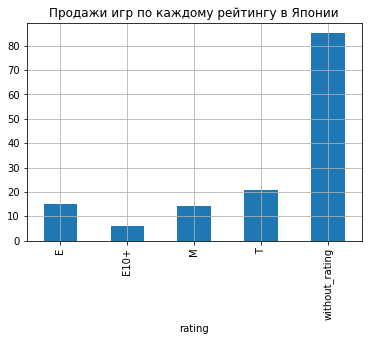

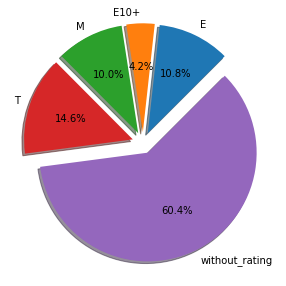

In [41]:
data_rating_jp = data_topical.groupby('rating')['jp_sales'].sum()
display(data_rating_jp)


data_rating_jp.plot(x='rating', y = 'jp_sales', kind = 'bar', \
                                        title = 'Продажи игр по каждому рейтингу в Японии', grid= True);

fig = plt.figure(figsize=(15,5))

data_rating_jp = data_rating_jp.reset_index()                                      
plt.pie(data_rating_jp['jp_sales'], labels = data_rating_jp['rating'], startangle=45 , \
        shadow='true', autopct='%1.1f%%', explode=[0.1,0.1,0.1, 0.1, 0.1]);

А вот популярные игры в Японии вообще не имеют рейтинга ESRB (почти 60%). Также стоит отметить бОльшую популярность игр для подростков в сравнении с Западом.

# 5 Проверим две гипотезы

### Гипотеза 1:
`Средние пользовательские рейтинги платформ Xbox One и PC одинаковые`

- Нулевая гипотеза Н0 - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
- Альтернативная гипотиза Н1- Средние пользовательские рейтинги платформ Xbox One и PC различны

Примем допустимый порог в 5% - так это обычный общепринятый достоверный порог значимости результатов

In [42]:
# расчитаем средние для обеих платформ
data_XOne = data_topical.query('platform == "XOne" & user_score>0')['user_score']
data_PC = data_topical.query('platform == "PC" & user_score>0')['user_score']
print('mean_XOne = ', data_XOne.mean())
print('mean_PC = ', data_PC.mean())

mean_XOne =  6.523
mean_PC =  6.27


Действительно расчитанные срнедние выборок очень близки.

Проведем т-тест Стьюдента, чтобы определить вероятьсть получить такие близкие по значению средние.

In [43]:
alpha = 0.05

# у нас две независимые выборки, поэтому используем ttest_ind
results = st.ttest_ind(data_XOne, data_PC, equal_var = True)
print('p-value=', results[1])

if (results[1] < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value= 0.13674832186577432
Не получилось отвергнуть нулевую гипотезу


Вероятность того, что у двух наших выборок средние одинаковы почти 30%, поэтому у нас нет оснований, чтобы отвергнуть Н0 и принять Н1.

### Гипотеза 2:
`Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные`
- Нулевая гипотеза Н0 - Средние пользовательские рейтинги жанров Action и Sports одинаковые
- Альтернативная гипотиза Н1- Средние пользовательские рейтинги жанров Action и Sports различны


In [44]:
# расчитаем средние
data_Action = data_topical.query('genre == "Action" & user_score>0')['user_score']
data_Sports = data_topical.query('genre == "Sports" & user_score>0')['user_score']
print('mean_Action = ', data_Action.mean())
print('mean_Sports = ', data_Sports.mean())

mean_Action =  6.84
mean_Sports =  5.24


Проведем т-тест Стьюдента, используя ttest_ind, так как у нас опять две независимые выборки

In [45]:
alpha = 0.05

results = st.ttest_ind(data_Action, data_Sports, equal_var = True)
print('p-value=', results[1])

if (results[1] < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value= 1.1751804617614683e-27
Отвергаем нулевую гипотезу


Верятность того, что средние в двух наших выборках будут одинаковыми - ничтожно мала. Поэтому гипотезу о том , что средние разные подтверждаем

# Общий вывод

Качество данных и предварительная обработка:
- данные полученные для исследования содержали значительное количество пропусков в графах оценок критиков и пользоватлей, а также отсутствовал у многих рейтинг ESRB
- при предобработке данных все значительные пропуски были заменены на "заглушки", чтобы не потерялась информативность датафрейма
- в нескольких столбцах был изменен тип данных на более подходящий и менее емкий
- дубликатов практически не было

Общие выводы:
- платформы имеют свой срок жизни на рынке. В большинстве случаев - это 10 лет.
- как только в мире появляются новые технологии, платформы прошлого поколения постепенно заменяются современными платформами за 2-3 года.
- для анализа имеет смысл использовать данные только за последние 2-3 года, так как тренды быстро меняются. Мы рассматривали только период 2013-2015 гг
- к 2013 году на рынок вышли две современные платформы PS4 и XOne, которые будут лидерами на ближайшие пару лет точно (2016-2018 гг).
- продажи игр не имеют особой зависимости с оценками критиков и пользователей 
- наиболее прибыльные игры в мире выпускаются в жанрах Экшн, Шутер, Ролевые игры и Спорт, но в жанре Экшн очень много игр, а популярны далеко не все. Зато Платформеров хоть и мало на рынке, в большинстве своем они очень популярны
- пользователи в Европе и Америке похожи по своим предпочтениям: им нравятся современные стационарные консоли и игры в жанрах Экшн, Шутер и Спорт
- японские пользователи в большинстве своем предпочитают портативные приставки и играют в Ролевые игры и Экшн
- Пользователи Западных стран предпочитают игры с рейтингами М и Е, а вот для японцев этот рейтинг не имеет особого значения

Выводы после проверки гипотез:
- гипотеза 1: с вероятность 30% средние пользовательские рейтинги платформ Xbox One и PC одинаковые
- гипотеза 2: верятность того, что средние пользовательские рейтинги жанров Action и Sports одинаковые - ничтожно мала.


